In [1]:
import h5py
import random
from scipy import ndimage
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
PATH_3D_H5 = 'Images/tof_data_128_112_40.hdf5'

def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    
    # Image matrices
    X = h5["X"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_pat), len(pat), len(path))

H5-file:  ['X', 'pat', 'path', 'stroke']
508 508 508 508


### Train, Test split

In [3]:
# consider stroke and no-stroke patients separately:
idx = np.where(Y_pat == 1)[0]
stroke_patients = np.unique(pat[idx])
idx = np.where(Y_pat == 0)[0]
non_stroke_patients = np.unique(pat[idx])
print(len(stroke_patients), len(non_stroke_patients))

# randomly shuffle the stroke and non-stroke patients
np.random.seed(1)
stroke_patients_test = np.random.choice(stroke_patients, size=len(stroke_patients), replace=False)
non_stroke_patients_test = np.random.choice(non_stroke_patients, size=len(non_stroke_patients), replace=False)

#test set
np.random.seed(1)
test_tmp = np.concatenate([stroke_patients_test[:70], non_stroke_patients_test[:31]], axis=0)
test = np.random.choice(test_tmp, size=len(test_tmp), replace=False)
len(test)

stroke_patients_run = [i for i in stroke_patients if i not in test]
non_stroke_patients_run = [i for i in non_stroke_patients if i not in test]

# randomply shuffle the data
np.random.seed(100)
stroke_patients_tmp = np.random.choice(stroke_patients_run, size=len(stroke_patients_run), replace=False)
non_stroke_patients_tmp = np.random.choice(non_stroke_patients_run, size=len(non_stroke_patients_run), replace=False)
print(len(stroke_patients_tmp), len(non_stroke_patients_tmp))

train_tmp = np.concatenate([stroke_patients_tmp,non_stroke_patients_tmp], axis=0)
print(len(train_tmp))

# randomly shuffle the datasets such that stroke and no-stroke patients are mixed
np.random.seed(100)
train = np.random.choice(train_tmp, size=len(train_tmp), replace=False)
test = np.random.choice(test, size=len(test), replace=False)
print(len(train), len(test))

351 157
281 126
407
407 101


In [4]:
def get_datasets(set_i, X, Y_pat, pat, path):
    Y_pat_set = []
    pat_set = []
    path_set = []
    # Find the indices corresponding to the patient_i in set_i
    idx = [i for i, pat_i in enumerate(pat) if pat_i in set_i]
    X_set = X[idx,:,:,:]
    for i in idx:
        Y_pat_set.append(Y_pat[i])
        pat_set.append(pat[i])
        path_set.append(path[i])     
    return(X_set, np.array(Y_pat_set), np.array(pat_set), np.array(path_set))

In [5]:
X_train, Y_train, pat_train, path_train = get_datasets(train, X, Y_pat, pat, path)
X_test, Y_test, pat_test, path_test = get_datasets(test, X, Y_pat, pat, path)

### Resize if necessary

In [ ]:
IMAGE_DIMENSION = (64, )

In [ ]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width = IMAGE_DIMENSION[0]
    desired_height = IMAGE_DIMENSION[1]
    desired_depth = IMAGE_DIMENSION[2]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [ ]:
X_train = np.array([resize_volume(img) for img in X_train])
X_test = np.array([resize_volume(img) for img in X_test])

### Preprocessing

In [6]:
#for softmax
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

#### Expand dimensions

In [7]:
X_train = np.expand_dims(X_train, axis = 4)
X_test = np.expand_dims(X_test, axis = 4)

#### Values between 0 and 255

In [8]:
def normalize(img):
    lmin = float(img.min())
    lmax = float(img.max())
    return np.floor((img - lmin)/(lmax - lmin)*255)

In [9]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

for i in range(X_train.shape[0]):
    X_train_norm[i] = normalize(X_train[i])  
    
print(X_train_norm.shape, X_train_norm.min(), X_train_norm.max())
    
for i in range(X_test.shape[0]):
    X_test_norm[i] = normalize(X_test[i])  

print(X_test_norm.shape, X_test_norm.min(), X_test_norm.max())

(407, 128, 112, 40, 1) 0 255
(101, 128, 112, 40, 1) 0 255


#### Z-Standardization

In [10]:
def z_normalize(array):
    array_z = (array - array.mean()) / array.std()
    return (array_z)

In [11]:
X_train_normz = np.array([z_normalize(img) for img in X_train_norm])
print(X_train_normz.shape, X_train_normz.min(), X_train_normz.max(), X_train_normz.mean(), X_train_normz.std())

X_test_normz = np.array([z_normalize(img) for img in X_test_norm])
print(X_test_normz.shape, X_test_normz.min(), X_test_normz.max(), X_test_normz.mean(), X_test_normz.std())

(407, 128, 112, 40, 1) -1.5907471988589987 26.031565772467758 2.723923812611388e-18 0.9999999999999996
(101, 128, 112, 40, 1) -1.5879721448660902 21.687867391483003 -4.553955829438408e-19 1.0000000000000024


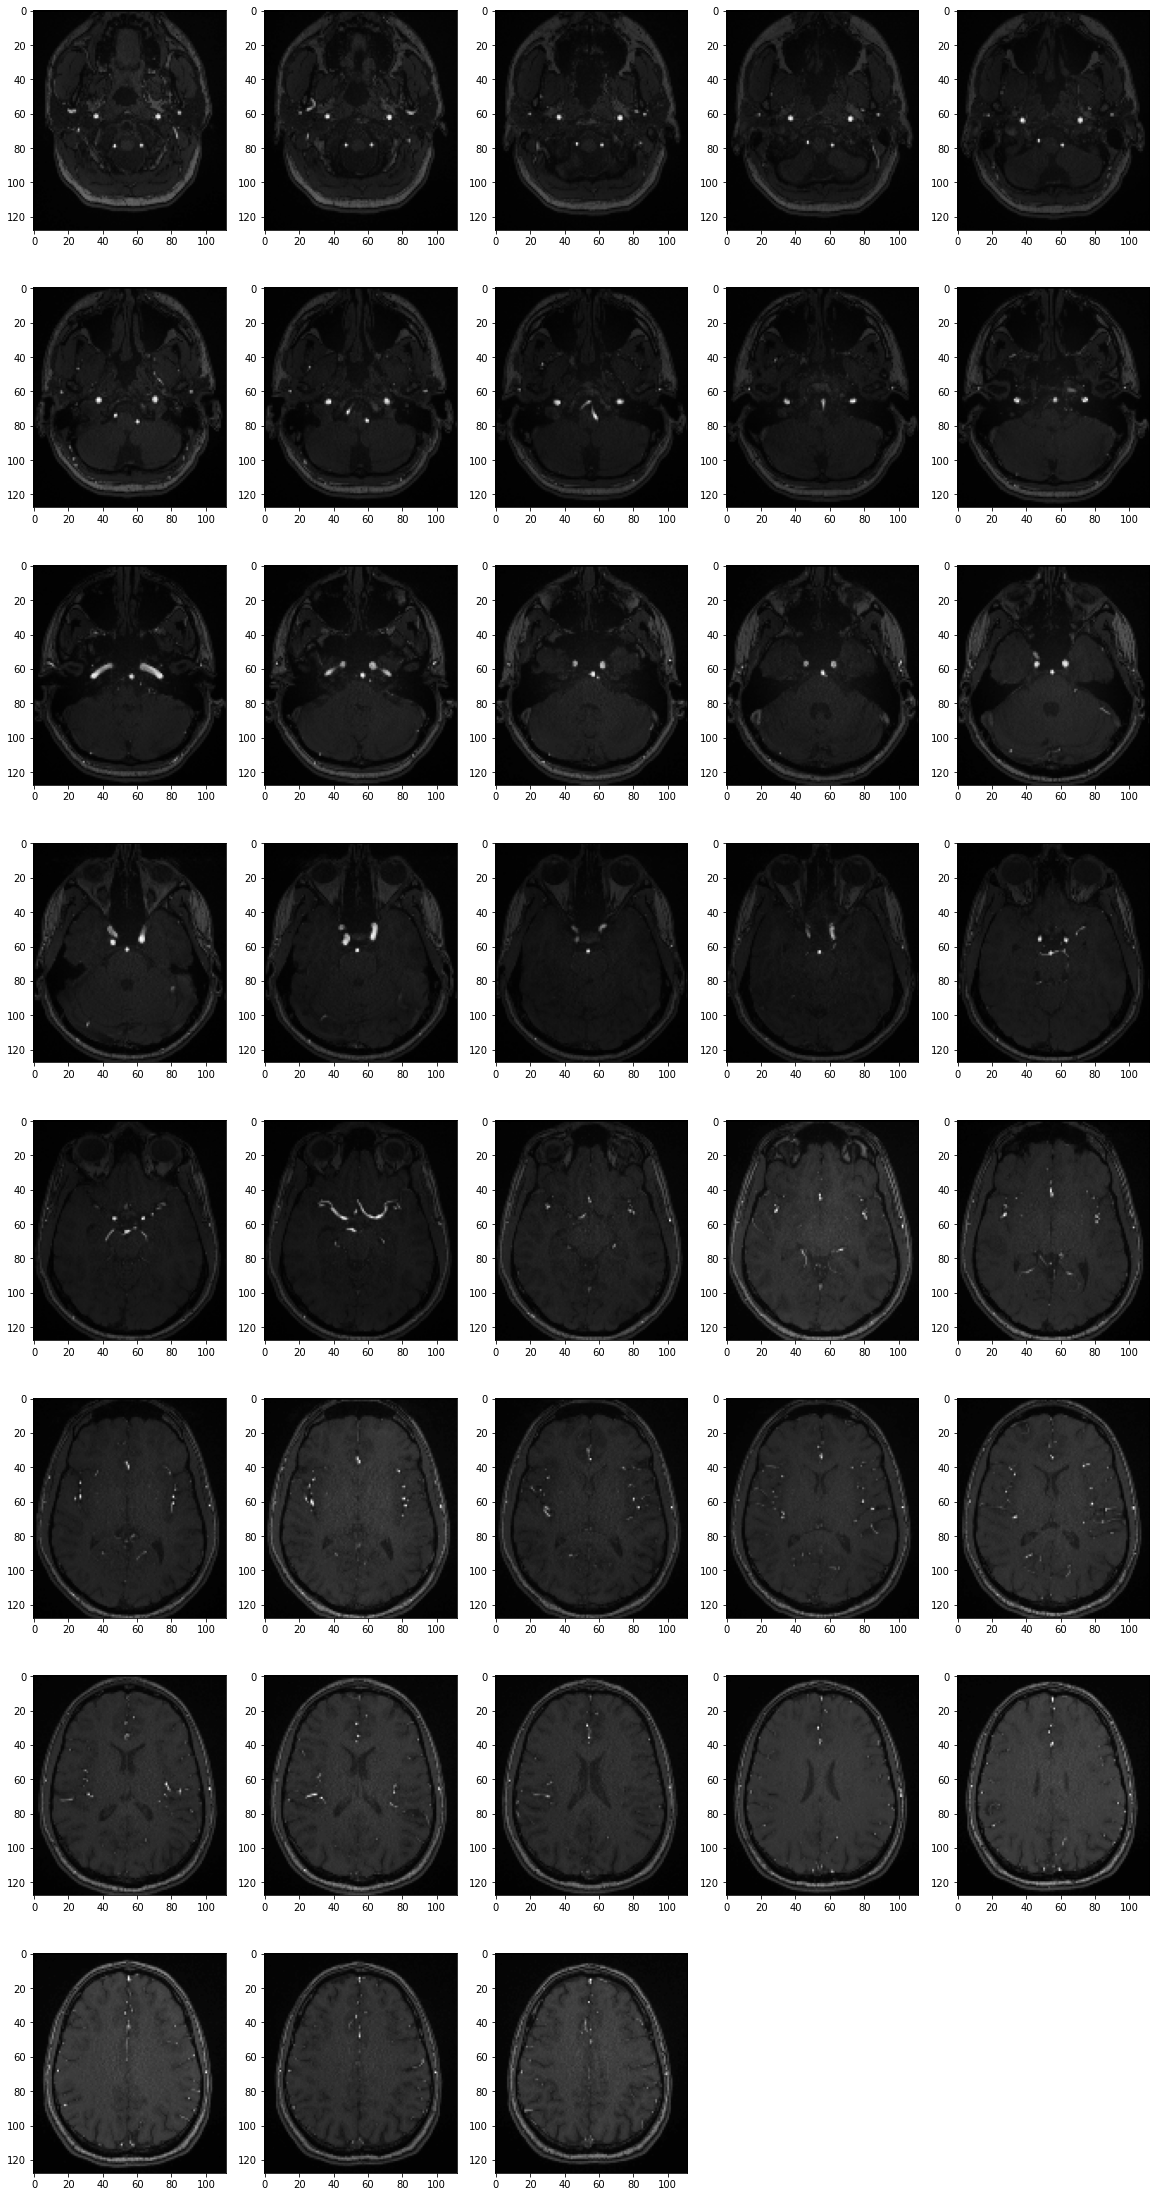

In [26]:
fig = plt.figure(figsize = (20, 40)) # total figure size (including all subplots)
fig_all = []
img = np.squeeze(X_train_normz[0], axis = 3)
for i in range(1, 39):
    image = img[:,:,i]
    fig_all.append(fig.add_subplot(8, 5, i))
    plt.imshow(image, cmap = 'gray')
plt.show()

In [ ]:
X_train_red = np.float(X_train_normz)
X_test_red = np.float32(X_test_normz)

#### Save in hdf5 file

In [28]:
# save the preprocessed data
with h5py.File('Images/preprocced_data.hdf5', "w") as h5:
    h5.create_dataset("X_train", data = X_train_normz)
    h5.create_dataset("Y_train", data = Y_train)
    h5.create_dataset("pat_train", data = pat_train)
    h5.create_dataset("X_test", data = X_test_normz)
    h5.create_dataset("Y_test", data = Y_test)
    h5.create_dataset("pat_test", data = pat_test)